In [1]:
 #Install packages

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 33.6 gigabytes of available RAM

You are using a high-RAM runtime!


#**BERT + TFIDF-Weighting**

In [3]:
import nltk
nltk.download('stop_words')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Error loading stop_words: Package 'stop_words' not found
[nltk_data]     in index
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\paul-\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\paul-\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from lightgbm import LGBMClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import warnings
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import torch.nn as nn
import numpy as np
import torch
from transformers import logging
from keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import logging
logging.set_verbosity_error()
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from transformers import  AutoModelForSequenceClassification
from transformers import AutoTokenizer, Trainer, TrainingArguments
from torch.utils.data import  Dataset
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import contractions
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# Text cleaning
import re
from sklearn.model_selection import train_test_split


from nltk.tokenize import word_tokenize
# Transformers library for BERT
from sklearn.metrics import classification_report, confusion_matrix


c:\Users\paul-\anaconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
logging.set_verbosity_error()

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))
# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

warnings.filterwarnings('ignore')

<Figure size 640x480 with 0 Axes>

In [6]:


# Load and shuffle data
df = pd.read_csv('http://prowess.co.ke/all_tickets.csv')
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,add to all seniors,tuesday december add seniors hello please add ...,1,4,1,7,36,3,4
1,belgrade move computers details needed,wednesday march pm move details needed hi plea...,1,6,22,21,45,3,4
2,cannot add several as pm to their project staff,care sa ii ca la fusion ne sa parte was invest...,0,1,36,0,67,1,3
3,lose access to project portfolio,lose access portfolio dear please open inciden...,0,4,51,78,46,1,3
4,windows forced upgrade,re forced upgrade reminder hello currently run...,1,5,15,88,32,3,4


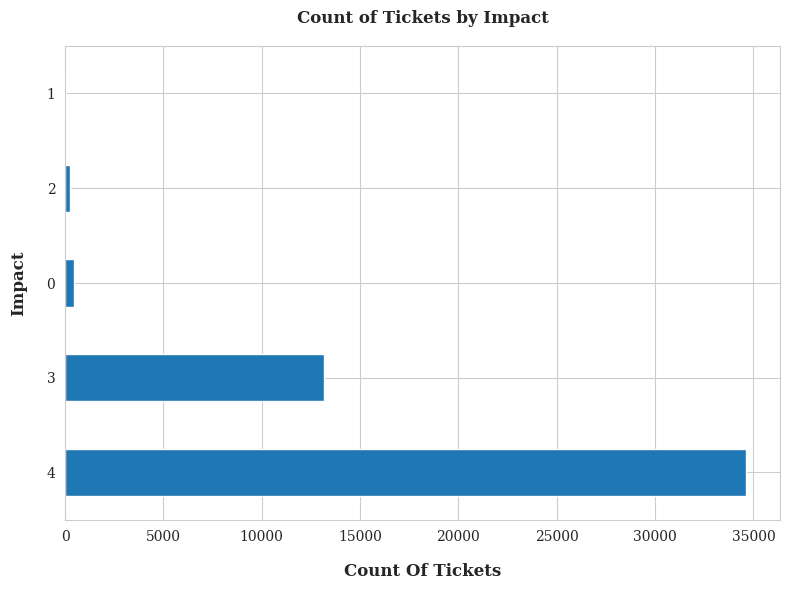

In [7]:

# Plot ticket counts by impact
sns.set_style({'font.family':'serif', 'font.serif':['Computer Modern'], 'font_scale':'1.4'})
df['impact'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count Of Tickets", labelpad=14)
plt.ylabel("Impact", labelpad=14)
plt.title("Count of Tickets by Impact", y=1.02)
plt.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48549 entries, 0 to 48548
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             47837 non-null  object
 1   body              48549 non-null  object
 2   ticket_type       48549 non-null  int64 
 3   category          48549 non-null  int64 
 4   sub_category1     48549 non-null  int64 
 5   sub_category2     48549 non-null  int64 
 6   business_service  48549 non-null  int64 
 7   urgency           48549 non-null  int64 
 8   impact            48549 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 3.3+ MB


In [9]:
df.impact.value_counts()

impact
4    34621
3    13184
0      471
2      228
1       45
Name: count, dtype: int64

   Severity levels targeting for:

---


    Critical/severe.
    Major/high.
    Medium.
    Minor/low.

In [10]:
df['impact'].value_counts()

impact
4    34621
3    13184
0      471
2      228
1       45
Name: count, dtype: int64

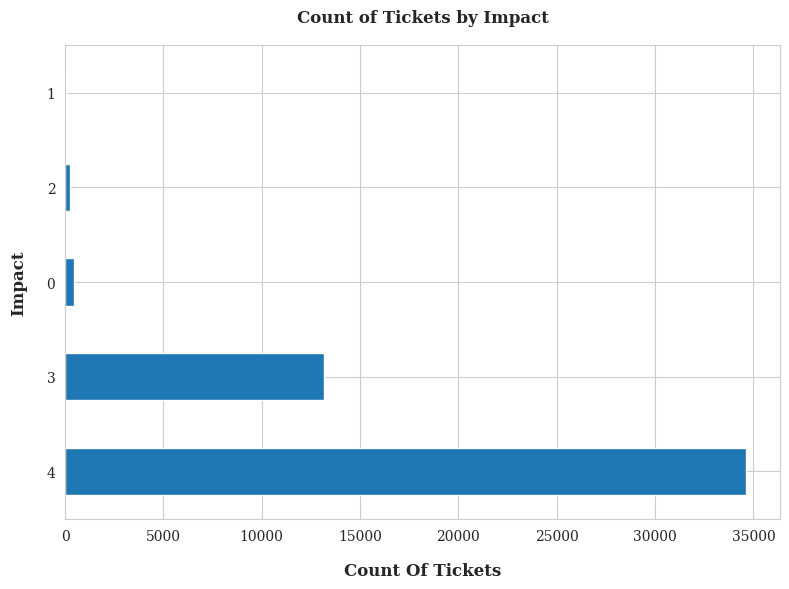

In [11]:
sns.set_style({'font.family':'serif', 'font.serif':['Computer Modern'] ,'font_scale':'1.4'  })
df['impact'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count Of Tickets", labelpad=14)
plt.ylabel("Impact", labelpad=14)
plt.title("Count of Tickets by Impact", y=1.02);

Text Cleaning

In [12]:
#Text  Cleaning
def strip_all_entities(body):
    body = re.sub(r'\r|\n', ' ', body.lower())  # Replace newline and carriage return with space, and convert to lowercase
    body = re.sub(r"(?:\@|https?\://)\S+", "", body)  # Remove links
    body = re.sub(r'[^\x00-\x7f]', '', body)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    body = body.translate(table)
    body = ' '.join(word for word in body.split() if word not in stop_words)
    return body
# Filter special characters such as & and $ present in some words
def filter_chars(body):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in body.split())

# Remove multiple spaces
def remove_mult_spaces(body):
    return re.sub(r"\s\s+", " ", body)
# Expand contractions
def expand_contractions(body):
    return contractions.fix(body)
# Remove numbers
def remove_numbers(body):
    return re.sub(r'\d+', '', body)
# Lemmatize words
def lemmatize(body):
    words = word_tokenize(body)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)
# Remove short words
def remove_short_words(body, min_len=2):
    words = body.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)
# Replace elongated words with their base form
def replace_elongated_words(body):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', body)
# Remove repeated punctuation
def remove_repeated_punctuation(body):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', body)
# Remove extra whitespace
def remove_extra_whitespace(body):
    return ' '.join(body.split())
def remove_url_shorteners(body):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', body)
# Remove short  tickets
def remove_short_tickets(ticket, min_words=0):    # We do not need this , real data world is not forgiving
    words = ticket.split()
    return ticket if len(words) >= min_words else ""

In [13]:
# Function to call all the cleaning functions in the correct order
def clean_ticket(ticket):
    ticket = expand_contractions(ticket)
    ticket = strip_all_entities(ticket)
    ticket = filter_chars(ticket)
    ticket = remove_mult_spaces(ticket)
    ticket = remove_numbers(ticket)
    ticket = lemmatize(ticket)
    ticket = remove_short_words(ticket)
    ticket = replace_elongated_words(ticket)
    ticket = remove_repeated_punctuation(ticket)
    ticket = remove_extra_whitespace(ticket)
    ticket = remove_url_shorteners(ticket)
    ticket = remove_short_tickets(ticket)
    ticket = ' '.join(ticket.split())  # Remove multiple spaces between words
    return ticket

In [14]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\paul-\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [15]:
df['text_clean'] = [clean_ticket(ticket) for ticket in df['body']]

In [16]:
df['label'] = df['impact'] + df['urgency']

In [17]:
df.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact,text_clean,label
0,add to all seniors,tuesday december add seniors hello please add ...,1,4,1,7,36,3,4,tuesday december add senior hello please add s...,7
1,belgrade move computers details needed,wednesday march pm move details needed hi plea...,1,6,22,21,45,3,4,wednesday march pm move detail needed hi pleas...,7
2,cannot add several as pm to their project staff,care sa ii ca la fusion ne sa parte was invest...,0,1,36,0,67,1,3,care sa ii ca la fusion ne sa parte investigat...,4
3,lose access to project portfolio,lose access portfolio dear please open inciden...,0,4,51,78,46,1,3,lose access portfolio dear please open inciden...,4
4,windows forced upgrade,re forced upgrade reminder hello currently run...,1,5,15,88,32,3,4,forced upgrade reminder hello currently runnin...,7


In [18]:
#df['labels'] = df['impact'].apply(lambda x: 0 if x == 0  else ( 0 if x == 1 else ( 0 if x == 2 else  ( 1 if x == 3 else  ( 2 if x == 4 else x ) )  )  ))
#df['labels'] = df['label'].apply(lambda x: 0 if x == 0  else ( 0 if x == 1 else ( 0 if x == 2 else  ( 0 if x == 3 else  ( 1 if x == 4 else  (2 if x == 4  else (3 if x == 5 else x )) ) )  )  ))
df['labels'] = df['label'].apply(lambda x: 0 if x == 0  else ( 0 if x == 1 else ( 0 if x == 2 else  ( 0 if x == 3 else  ( 1 if x == 4 else  (2 if x == 5  else (3 if x == 7 else 3 )) ) )  )  ))


In [19]:
labels = df['labels'].unique().tolist()
labels

[3, 1, 0, 2]

In [20]:
for key, value in enumerate(labels):
  print(value)

3
1
0
2


In [21]:
df.labels.value_counts()

labels
3    34621
1     6552
2     5237
0     2139
Name: count, dtype: int64

In [22]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [23]:
label2id

{3: 0, 1: 1, 0: 2, 2: 3}

In [24]:
id2label

{0: 3, 1: 1, 2: 0, 3: 2}

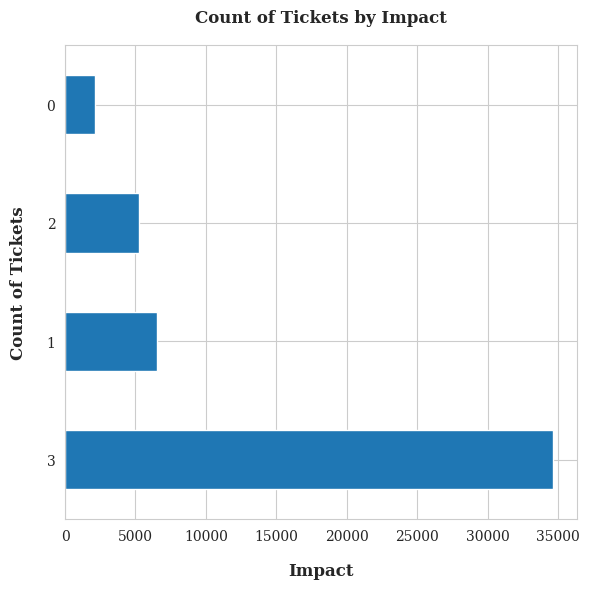

In [25]:
sns.set_style({'font.family':'serif', 'font.serif':['modern serif font'] ,'font_scale':'1.4'  })
df['labels'].value_counts().plot(kind='barh', figsize=(6, 6))
plt.xlabel("Impact", labelpad=14)
plt.ylabel("Count of Tickets", labelpad=14)
plt.title("Count of Tickets by Impact", y=1.02);

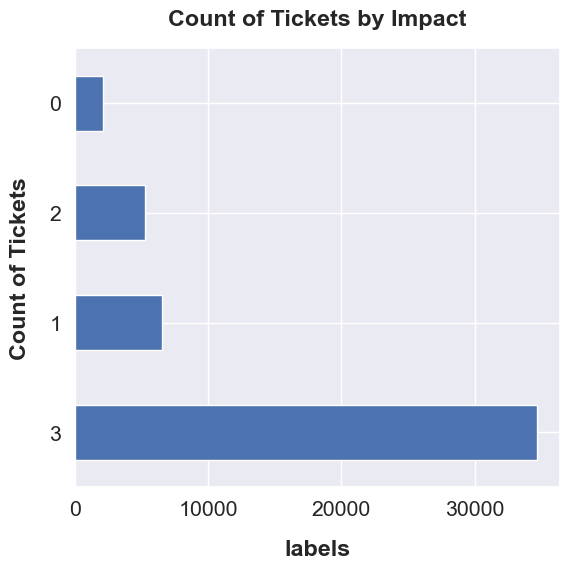

In [26]:
sns.set(font_scale=1.4)
df['labels'].value_counts().plot(kind='barh', figsize=(6, 6), rot=0)
plt.xlabel("labels", labelpad=14)
plt.ylabel("Count of Tickets", labelpad=14)
plt.title("Count of Tickets by Impact", y=1.02);


<Axes: ylabel='count'>

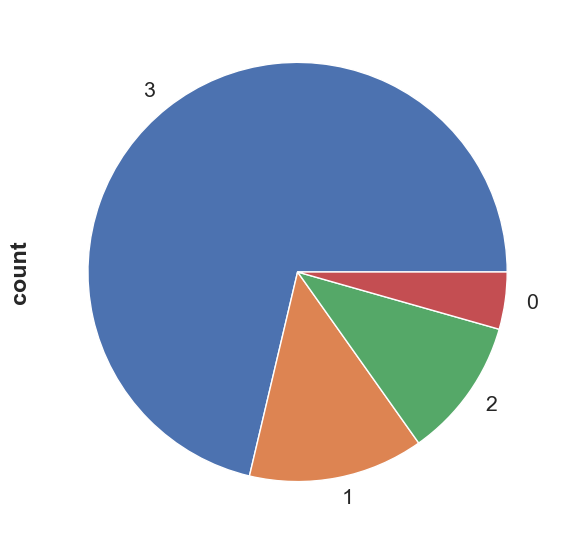

In [27]:
df.labels.value_counts().plot(kind='pie', figsize=(6,6))

In [28]:
df = df[['text_clean','labels', 'impact']]

In [29]:
X = df['text_clean']
y = df['labels']

In [30]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1 , stratify=y, )
 X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, random_state=1 , stratify=y_train, ) # 0.25 x 0.8 = 0.2

In [31]:
model =AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
##model.to(device)
model.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [32]:
train_texts   =   list(X_train)
train_labels  =   list(y_train)
test_texts    =   list(X_test)
test_labels   =   list(y_test)
val_texts     =   list(X_val)
val_labels    =   list(y_val)

In [33]:
from pathlib import Path
Path('/content/drive/My Drive').mkdir(exist_ok=True, parents=True)

In [34]:
import joblib

# Your train_test_split code here
# Save the datasets to Google Drive
joblib.dump(X_train, '/content/drive/My Drive/X_train.pkl')
joblib.dump(X_test, '/content/drive/My Drive/X_test.pkl')
joblib.dump(y_train, '/content/drive/My Drive/y_train.pkl')
joblib.dump(y_test, '/content/drive/My Drive/y_test.pkl')
joblib.dump(X_val, '/content/drive/My Drive/X_val.pkl')
joblib.dump(y_val, '/content/drive/My Drive/y_val.pkl')



# Save the model and variables
model_save_path = '/content/drive/My Drive/model.pth'
variables_save_path = '/content/drive/My Drive/model_variables.pth'

torch.save(model.state_dict(), model_save_path)
torch.save({'num_labels': NUM_LABELS, 'id2label': id2label, 'label2id': label2id}, variables_save_path)

print(f"Model saved to {model_save_path}")
print(f"Variables saved to {variables_save_path}")


Model saved to /content/drive/My Drive/model.pth
Variables saved to /content/drive/My Drive/model_variables.pth


In [35]:
tokenizer =  AutoTokenizer.from_pretrained('bert-base-uncased', max_length=1024)

In [36]:
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                    )
class_weights
print("Class Weights:",class_weights)
weights= torch.tensor(class_weights,dtype=torch.float)
weights
# push to GPU
weights = weights.to(device)
weights

Class Weights: [5.67595479 1.85251844 2.31771165 0.35056323]


tensor([5.6760, 1.8525, 2.3177, 0.3506])

In [37]:
#class_weights= (1- (y_train.value_counts().sort_index() / len(y_train))).values
#class_weights = torch.from_numpy(class_weights).float().to("cuda")

In [38]:
# Save class weights to a file in Google Drive
weights_path = '/content/drive/My Drive/class_weights.npy'
np.save(weights_path, class_weights)
print(f"Class weights saved to {weights_path}")


Class weights saved to /content/drive/My Drive/class_weights.npy


In [39]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
# Create TF-IDF representations
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Combine BERT embeddings with TF-IDF representations
train_encodings['tfidf'] = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32).tolist()
val_encodings['tfidf'] = torch.tensor(X_val_tfidf.toarray(), dtype=torch.float32).tolist()
test_encodings['tfidf'] = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32).tolist()


In [49]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels=None, tfidf_weights=None):
        self.encodings = encodings
        self.labels = labels
        self.tfidf_weights = tfidf_weights

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        if self.tfidf_weights is not None:
            item['tfidf_weights'] = torch.tensor(self.tfidf_weights[idx].toarray()).float()
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = CustomDataset(train_encodings, train_labels, X_train_tfidf)
val_dataset = CustomDataset(val_encodings, val_labels, X_val_tfidf)
test_dataset = CustomDataset(test_encodings, test_labels, X_test_tfidf)

class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = inputs.get("labels")
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights, reduction='none')
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        if "tfidf_weights" in inputs:
            tfidf_weights = inputs.pop("tfidf_weights")
            tfidf_weights = tfidf_weights.view(-1, 1).expand(-1, self.model.config.num_labels).contiguous()
            loss = loss * tfidf_weights
        return (loss.mean(), outputs) if return_outputs else loss.mean()

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1-score': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./multi-class-logs',
    do_train=True,
    do_eval=True,
    num_train_epochs=7,
    learning_rate=5e-5,
    torch_compile=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=200,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=500,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    load_best_model_at_end=True,
    fp16=True,
    optim="adamw_torch_fused"
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)




In [50]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [51]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [52]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


In [53]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch._dynamo
torch._dynamo.config.suppress_errors = True

%env TOKENIZERS_PARALLELISM=true


env: TOKENIZERS_PARALLELISM=true


In [54]:
trainer.train()

W0424 10:03:10.101000 21172 site-packages\torch\_dynamo\convert_frame.py:1280] WON'T CONVERT forward c:\Users\paul-\anaconda3\envs\py311\Lib\site-packages\transformers\models\bert\modeling_bert.py line 1646 
W0424 10:03:10.101000 21172 site-packages\torch\_dynamo\convert_frame.py:1280] due to: 
W0424 10:03:10.101000 21172 site-packages\torch\_dynamo\convert_frame.py:1280] Traceback (most recent call last):
W0424 10:03:10.101000 21172 site-packages\torch\_dynamo\convert_frame.py:1280]   File "c:\Users\paul-\anaconda3\envs\py311\Lib\site-packages\torch\_dynamo\convert_frame.py", line 1213, in __call__
W0424 10:03:10.101000 21172 site-packages\torch\_dynamo\convert_frame.py:1280]     result = self._inner_convert(
W0424 10:03:10.101000 21172 site-packages\torch\_dynamo\convert_frame.py:1280]              ^^^^^^^^^^^^^^^^^^^^
W0424 10:03:10.101000 21172 site-packages\torch\_dynamo\convert_frame.py:1280]   File "c:\Users\paul-\anaconda3\envs\py311\Lib\site-packages\torch\_dynamo\convert_fram

KeyboardInterrupt: 

In [ ]:
q=[trainer.evaluate(eval_dataset=df) for df in [train_dataset, val_dataset, test_dataset]]
pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

In [ ]:
 # Evaluate the model
results = trainer.evaluate()


In [ ]:
print(results)

In [ ]:
val_predictions = trainer.predict(val_dataset)
val_predicted_labels = val_predictions.predictions.argmax(axis=1)


In [ ]:
val_predicted_labels = val_predictions.predictions.argmax(axis=1)

In [ ]:
print(classification_report(val_labels, val_predicted_labels))

In [ ]:
test_predictions = trainer.predict(test_dataset)
test_predicted_labels = test_predictions.predictions.argmax(axis=1)

In [ ]:
print(classification_report(test_labels, test_predicted_labels))

In [ ]:
cf_matrixbrt = confusion_matrix(test_predicted_labels,test_labels)
cf_matrixbrt

In [ ]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(cf_matrixbrt, cmap="Blues",  annot=True, annot_kws={"size": 12}  , cbar=True, fmt='g' )
# Set the axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [ ]:
sns.heatmap(cf_matrixbrt , annot=True, annot_kws={"size": 12} , cmap='Blues', cbar=True, fmt='g' )
# Set the axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [ ]:
# Predictions
y_test_predict = trainer.predict(test_dataset)
# Take a look at the predictions
y_test_predict

In [ ]:
# Predicted logits
y_test_logits = y_test_predict.predictions
# First 5 predicted probabilities
y_test_logits[:5]

In [ ]:
# Predicted probabilities
y_test_probabilities = tf.nn.softmax(y_test_logits)
# First 5 predicted logits
y_test_probabilities[:5]

In [ ]:
# Define the path where you want to save the file
file_path = '/content/drive/My Drive/test_predicted_labels.npy'
# Save the numpy array to the file
np.save(file_path, test_predicted_labels)
print(f'Saved test_predicted_labels to {file_path}')

In [ ]:

metrics = ["accuracy", "precision", "recall", "f1-score"] # define metrics
models = [   "BERT + TF-IDF"  ] # define models
results = [] # initialize results list
for y_pred in [  test_predicted_labels       ]: # iterate over predictions
  result = [] # initialize result list for each model
  for metric in metrics: # iterate over metrics
    if metric == "accuracy":
      score = accuracy_score(y_test, y_pred) # calculate accuracy
    elif metric == "precision":
      score = precision_score(y_test, y_pred, average="weighted") # calculate macro-averaged precision
    elif metric == "recall":
      score = recall_score(y_test, y_pred, average="weighted") # calculate macro-averaged recall
    elif metric == "f1-score":
      score = f1_score(y_test, y_pred, average="weighted") # calculate macro-averaged F1-score
    result.append(score) # add score to result list
  results.append(result) # add result list to results list

# Create table with results
table = pd.DataFrame(results, index=models, columns=metrics) # create dataframe with results
print(table) # print table


In [ ]:
metrics = ["accuracy", "precision", "recall", "f1-score"] # Define metrics
models = ["BERT + TF-IDF"] # Define models
results = [] # Initialize results list

# Iterate over predictions
for y_pred in [test_predicted_labels]:
    result = [] # Initialize result list for each model
    for metric in metrics: # Iterate over metrics
        if metric == "accuracy":
            score = accuracy_score(y_test, y_pred) # Calculate accuracy
        elif metric == "precision":
            score = precision_score(y_test, y_pred, average="weighted") # Calculate macro-averaged precision
        elif metric == "recall":
            score = recall_score(y_test, y_pred, average="weighted") # Calculate macro-averaged recall
        elif metric == "f1-score":
            score = f1_score(y_test, y_pred, average="weighted") # Calculate macro-averaged F1-score
        result.append(score) # Add score to result list
    results.append(result) # Add result list to results list

# Create table with results
table = pd.DataFrame(results, index=models, columns=metrics) # Create dataframe with results
print(table) # Print table


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.metrics import Precision, Recall

# **BERT TFIDF + LSTM**

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.train()

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', max_length=1024)

train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# TF-IDF Preparation
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# LSTM Model Preparation
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100

tokenizer_lstm = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_lstm.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer_lstm.texts_to_sequences(X_train), maxlen=MAX_SEQUENCE_LENGTH)
X_val_seq = pad_sequences(tokenizer_lstm.texts_to_sequences(X_val), maxlen=MAX_SEQUENCE_LENGTH)
X_test_seq = pad_sequences(tokenizer_lstm.texts_to_sequences(X_test), maxlen=MAX_SEQUENCE_LENGTH)

lstm_model = Sequential([
    Embedding(MAX_VOCAB_SIZE, 128, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64),
    Dense(NUM_LABELS, activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


class CustomDataset(Dataset):
    def __init__(self, encodings, labels, tfidf_weights=None):
        self.encodings = encodings
        self.labels = labels
        self.tfidf_weights = tfidf_weights

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Access labels using the index from encodings to ensure alignment
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        if self.tfidf_weights is not None:
            item['tfidf_weights'] = torch.tensor(self.tfidf_weights[idx].toarray()).float()
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = CustomDataset(train_encodings, y_train, X_train_tfidf)
val_dataset = CustomDataset(val_encodings, y_val, X_val_tfidf)
test_dataset = CustomDataset(test_encodings, y_test, X_test_tfidf)

# Trainer with Weighted Loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = inputs.get("labels")
        loss_fct = nn.CrossEntropyLoss(weight=weights, reduction='none')
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        if "tfidf_weights" in inputs:
            tfidf_weights = inputs.pop("tfidf_weights")
            tfidf_weights = tfidf_weights.view(-1, 1).expand(-1, self.model.config.num_labels).contiguous()
            loss = loss * tfidf_weights
        return (loss.mean(), outputs) if return_outputs else loss.mean()

# Compute Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1-score': f1,
        'precision': precision,
        'recall': recall
    }

# Training Arguments
training_args = TrainingArguments(
    output_dir='./multi-class-logs',
    do_train=True,
    do_eval=True,
    num_train_epochs=7,
    learning_rate=5e-5,
    torch_compile=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=200,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=500,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    load_best_model_at_end=True,
    fp16=True,
    optim="adamw_torch_fused"
)

# Initialize Trainer
trainerl = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainerl.train()




In [ ]:

# Train LSTM model
lstm_model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), epochs=7, batch_size=64)


In [ ]:

# Train LSTM model
lstm_model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), epochs=7, batch_size=64)


In [ ]:
# Evaluate the model on the validation dataset
eval_results = trainerl.evaluate()

# Print the evaluation metrics
accuracy = eval_results['eval_accuracy']
precision = eval_results['eval_precision']
recall = eval_results['eval_recall']
f1 = eval_results['eval_f1-score']

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

In [ ]:

# Evaluate the model on the test dataset
test_results = trainerl.predict(test_dataset)

# Extract metrics
accuracy = test_results.metrics['test_accuracy']
precision = test_results.metrics['test_precision']
recall = test_results.metrics['test_recall']
f1 = test_results.metrics['test_f1-score']

# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Evaluate the model on the test dataset
test_results = trainerl.predict(test_dataset)

# Extract true labels and predicted labels
y_true = test_results.label_ids
y_pred = np.argmax(test_results.predictions, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix as an array
print('Confusion Matrix as an Array:')
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

accuracy = test_results.metrics['test_accuracy']
precision = test_results.metrics['test_precision']
recall = test_results.metrics['test_recall']
f1 = test_results.metrics['test_f1-score']



In [ ]:

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:

accuracy = test_results.metrics['test_accuracy']
precision = test_results.metrics['test_precision']
recall = test_results.metrics['test_recall']
f1 = test_results.metrics['test_f1-score']



In [ ]:

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

LSTM Part

In [ ]:
y_pred = lstm_model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

In [ ]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Evaluate the model on the validation dataset
eval_results = trainerl.evaluate()

# Print the evaluation metrics
accuracy = eval_results['eval_accuracy']
precision = eval_results['eval_precision']
recall = eval_results['eval_recall']
f1 = eval_results['eval_f1-score']

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')



# Evaluate the model on the test dataset
test_results = trainerl.predict(test_dataset)

# Extract metrics
accuracy = test_results.metrics['test_accuracy']
precision = test_results.metrics['test_precision']
recall = test_results.metrics['test_recall']
f1 = test_results.metrics['test_f1-score']

# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

In [ ]:
# Predictions and Voting Ensemble
bert_preds = trainerl.predict(test_dataset).predictions.argmax(-1)
tfidf_preds = trainerl.predict(test_dataset).predictions.argmax(-1)
lstm_preds = lstm_model.predict(X_test_seq).argmax(axis=1)

final_preds = []
for bert, tfidf, lstm in zip(bert_preds, tfidf_preds, lstm_preds):
    votes = [bert, tfidf, lstm]
    final_preds.append(max(set(votes), key=votes.count))

# Evaluation
accuracy = accuracy_score(y_test, final_preds)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, final_preds, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

In [ ]:

# Confusion Matrix
cm = confusion_matrix(y_test, final_preds)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Confusion matrix as array
conf_matrix = confusion_matrix(y_test, final_preds)
print("Confusion Matrix (as array):")
print(conf_matrix)

In [ ]:
# Confusion matrix as image
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

metrics = ["accuracy", "precision", "recall", "f1-score"]
models = ["BERT + TF-IDF + LSTM   "]
results = []

for y_pred in [final_preds]:
    result = []
    for metric in metrics:
        if metric == "accuracy":
            score = accuracy_score(y_test, y_pred)
        elif metric == "precision":
            score = precision_score(y_test, y_pred, average="weighted")
        elif metric == "recall":
            score = recall_score(y_test, y_pred, average="weighted")
        elif metric == "f1-score":
            score = f1_score(y_test, y_pred, average="weighted")
        result.append(score)
    results.append(result)

# Create table with results
table = pd.DataFrame(results, index=models, columns=metrics)
print(table)


# **BERT + TFIDF + LSTM+lightGBM**

In [ ]:
# LightGBM Model Training
lgbm = LGBMClassifier()
lgbm.fit(X_train_tfidf, y_train)

# Predictions from BERT and LightGBM
bert_predictions = trainer.predict(test_dataset).predictions.argmax(-1)
lgbm_predictions = lgbm.predict(X_test_tfidf)

#y_pred = lstm_model.predict(X_test_seq)
#y_pred_classes = np.argmax(y_pred, axis=1)
#lstm_preds = lstm_model.predict(X_test_seq).argmax(axis=1)


# Combining Predictions
final_predictions = (bert_predictions + lstm_preds + lgbm_predictions  ) // 3

# Evaluation
accuracy = accuracy_score(y_test, final_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, final_predictions, average='weighted')


In [ ]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Create confusion matrix as an array
conf_matrix = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix as an array:")
print(conf_matrix)



In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

metrics = ["accuracy", "precision", "recall", "f1-score"]
models = ["BERT + TF-IDF + LSTM + LightGBM  "]
results = []

for y_pred in [final_predictions]:
    result = []
    for metric in metrics:
        if metric == "accuracy":
            score = accuracy_score(y_test, y_pred)
        elif metric == "precision":
            score = precision_score(y_test, y_pred, average="weighted")
        elif metric == "recall":
            score = recall_score(y_test, y_pred, average="weighted")
        elif metric == "f1-score":
            score = f1_score(y_test, y_pred, average="weighted")
        result.append(score)
    results.append(result)

# Create table with results
table = pd.DataFrame(results, index=models, columns=metrics)
print(table)

In [ ]:
# Predictions and Voting Ensemble
bert_preds = trainerl.predict(test_dataset).predictions.argmax(-1)
tfidf_preds = trainerl.predict(test_dataset).predictions.argmax(-1)
lstm_preds = lstm_model.predict(X_test_seq).argmax(axis=1)
lgbm_preds = lgbm.predict(X_test_tfidf)

final_preds = []
for bert, tfidf, lstm ,lgbm_preds in zip(bert_preds, tfidf_preds, lstm_preds, lgbm_preds):
    votes = [bert, tfidf, lstm, lgbm_preds]
    final_preds.append(max(set(votes), key=votes.count))

# Evaluation
accuracy = accuracy_score(y_test, final_preds)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, final_preds, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

In [ ]:
metrics = ["accuracy", "precision", "recall", "f1-score"]
models = ["BERT + TF-IDF + LSTM + LightGBM  "]
results = []

for y_pred in [final_preds]:
    result = []
    for metric in metrics:
        if metric == "accuracy":
            score = accuracy_score(y_test, y_pred)
        elif metric == "precision":
            score = precision_score(y_test, y_pred, average="weighted")
        elif metric == "recall":
            score = recall_score(y_test, y_pred, average="weighted")
        elif metric == "f1-score":
            score = f1_score(y_test, y_pred, average="weighted")
        result.append(score)
    results.append(result)

# Create table with results
table = pd.DataFrame(results, index=models, columns=metrics)
print(table)

In [ ]:

# Confusion Matrix
conf_matrixs = confusion_matrix(y_test, final_preds)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrixs, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
# Confusion matrix as array
conf_matrix = confusion_matrix(y_test, final_preds)
print("Confusion Matrix (as array):")
print(conf_matrixs)

In [ ]:
import joblib
from google.colab import drive
drive.mount('/content/drive')
import numpy as np  # Import NumPy library import numpy as np  # Import NumPy library
import torch # Import PyTorch

# Load the datasets from Google Drive
X_train = joblib.load('/content/drive/My Drive/X_train.pkl')
X_test = joblib.load('/content/drive/My Drive/X_test.pkl')
y_train = joblib.load('/content/drive/My Drive/y_train.pkl')
y_test = joblib.load('/content/drive/My Drive/y_test.pkl')
X_val = joblib.load('/content/drive/My Drive/X_val.pkl')
y_val = joblib.load('/content/drive/My Drive/y_val.pkl')
# Define paths
model_save_path = '/content/drive/My Drive/model.pth'
variables_save_path = '/content/drive/My Drive/model_variables.pth'

train_texts   =   list(X_train)
train_labels  =   list(y_train)
test_texts    =   list(X_test)
test_labels   =   list(y_test)
val_texts     =   list(X_val)
val_labels    =   list(y_val)

# Define paths
model_save_path = '/content/drive/My Drive/model.pth'
variables_save_path = '/content/drive/My Drive/model_variables.pth'
# Save class weights to a file in Google Drive
weights_path = '/content/drive/My Drive/class_weights.npy'

# Load variables
loaded_variables = torch.load(variables_save_path)
NUM_LABELS = loaded_variables['num_labels']
id2label = loaded_variables['id2label']
label2id = loaded_variables['label2id']

#**Other Models**

After dividing the dataset, the subsequent stages involve feature manipulation. Initially, we'll change our textual documents into a matrix that counts tokens using CountVectorizer. Subsequently, we'll convert the count matrix into a normalized tf-idf representation using the tf-idf transformer. Following this, we will proceed to train various classifiers from the Scikit-Learn library.

#  Naive Bayes Classifier for Multinomial Models

In [ ]:
#  Naive Bayes Classifier for Multinomial Models
#To make the vectorizer => transformer => classifier easier to work with, we will use Pipeline class in Scilkit-Learn that behaves like a compound classifier.

In [ ]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [ ]:
nb.fit(X_train, y_train)

In [ ]:
%%time
from sklearn.metrics import classification_report
y_prednb = nb.predict(X_test)

In [ ]:
print(classification_report(y_test, y_prednb))

In [ ]:
cf_matrixnb = confusion_matrix(y_prednb,test_labels)
cf_matrixnb

In [ ]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(cf_matrixnb, cmap="Blues",  annot=True, annot_kws={"size": 12}  , cbar=True, fmt='g' )
# Set the axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


In [ ]:
# Make predictions on the test set
y_prednb = nb.predict(X_test)

# Compute the metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_prednb, average='weighted')

# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

In [ ]:
# Define the path where you want to save the file
file_path = '/content/drive/My Drive/y_prednb.npy'
# Save the numpy array to the file
np.save(file_path, y_prednb)
print(f'Saved  predicted_labels to {file_path}')

In [ ]:
metrics = ["accuracy", "precision", "recall", "f1-score"] # define metrics
models = [   "Naive Bayes  "  ] # define models
results = [] # initialize results list
for y_pred in [   y_prednb      ]: # iterate over predictions
  result = [] # initialize result list for each model
  for metric in metrics: # iterate over metrics
    if metric == "accuracy":
      score = accuracy_score(y_test, y_pred) # calculate accuracy
    elif metric == "precision":
      score = precision_score(y_test, y_pred, average="weighted") #
    elif metric == "recall":
      score = recall_score(y_test, y_pred, average="weighted") #
    elif metric == "f1-score":
      score = f1_score(y_test, y_pred, average="weighted") #
    result.append(score) # add score to result list
  results.append(result) # add result list to results list

# Create table with results
table = pd.DataFrame(results, index=models, columns=metrics) # create dataframe with results
print(table) # print table


#**Linear Support Vector Machine**

In [ ]:
###   Linear Support Vector Machine
##   Linear Support Vector Machine is widely regarded as one of the best text classification algorithms.
#To make the vectorizer => transformer => classifier easier to work with, we will use Pipeline class in Scilkit-Learn that behaves like a compound classifier.

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

In [ ]:
sgd.fit(X_train, y_train)
#%%time
y_predlsvm = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_predlsvm, y_test))

In [ ]:
print(classification_report(y_test, y_predlsvm))

In [ ]:
cf_matrixsvm = confusion_matrix(y_predlsvm,test_labels)
cf_matrixsvm

In [ ]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(cf_matrixsvm, cmap="Blues",  annot=True, annot_kws={"size": 12}  , cbar=True, fmt='g' )
# Set the axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


In [ ]:
# Define the path where you want to save the file
file_path = '/content/drive/My Drive/y_predlsvm.npy'
# Save the numpy array to the file
np.save(file_path, y_predlsvm )
print(f'Saved  predicted_labels to {file_path}')

In [ ]:
# Make predictions on the test set
y_predlsvm = sgd.predict(X_test)

# Compute the metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_predlsvm, average='weighted')

# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

In [ ]:
metrics = ["accuracy", "precision", "recall", "f1-score"] # define metrics
models = [   "Linear Support Vector Machine"  ] # define models
results = [] # initialize results list
for y_pred in [  y_predlsvm      ]: # iterate over predictions
  result = [] # initialize result list for each model
  for metric in metrics: # iterate over metrics
    if metric == "accuracy":
      score = accuracy_score(y_test, y_pred) # calculate accuracy
    elif metric == "precision":
      score = precision_score(y_test, y_pred, average="weighted") # calculate macro-averaged precision
    elif metric == "recall":
      score = recall_score(y_test, y_pred, average="weighted") # calculate macro-averaged recall
    elif metric == "f1-score":
      score = f1_score(y_test, y_pred, average="weighted") # calculate macro-averaged F1-score
    result.append(score) # add score to result list
  results.append(result) # add result list to results list

# Create table with results
table = pd.DataFrame(results, index=models, columns=metrics) # create dataframe with results
print(table) # print table


#**RandomForest**

In [ ]:
#To make the vectorizer => transformer => classifier easier to work with, we will use Pipeline class in Scilkit-Learn that behaves like a compound classifier.

In [ ]:
RandomForest = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())
               ])

In [ ]:
RandomForest.fit(X_train, y_train)

In [ ]:
y_predrf = RandomForest.predict(X_test)

print('accuracy %s' % accuracy_score(y_predrf, y_test))

In [ ]:
print(classification_report(y_test, y_predrf))

In [ ]:
cf_matrixrf = confusion_matrix(y_predrf,test_labels)
cf_matrixrf

In [ ]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(cf_matrixrf, cmap="Blues",  annot=True, annot_kws={"size": 12}  , cbar=True, fmt='g' )
# Set the axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [ ]:
# Define the path where you want to save the file
file_path = '/content/drive/My Drive/y_predrf.npy'
# Save the numpy array to the file
np.save(file_path, y_predrf )
print(f'Saved  predicted_labels to {file_path}')

In [ ]:
# Make predictions on the test set
y_predrf = RandomForest.predict(X_test)

# Compute the metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_predrf , average='weighted')

# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

In [ ]:
metrics = ["accuracy", "precision", "recall", "f1-score"] # define metrics
models = [   "Randon Forest "  ] # define models
results = [] # initialize results list
for y_pred in [  y_predrf      ]: # iterate over predictions
  result = [] # initialize result list for each model
  for metric in metrics: # iterate over metrics
    if metric == "accuracy":
      score = accuracy_score(y_test, y_pred) # calculate accuracy
    elif metric == "precision":
      score = precision_score(y_test, y_pred, average="weighted") #
    elif metric == "recall":
      score = recall_score(y_test, y_pred, average="weighted") #
    elif metric == "f1-score":
      score = f1_score(y_test, y_pred, average="weighted") #
    result.append(score) # add score to result list
  results.append(result) # add result list to results list

# Create table with results
table = pd.DataFrame(results, index=models, columns=metrics) # create dataframe with results
print(table) # print table


#**Decision Tree**

In [ ]:
# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtree_model = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf',  DecisionTreeClassifier()),
              ])

In [ ]:
dtree_model.fit(X_train, y_train)

In [ ]:
y_preddt = dtree_model.predict(X_test)

print('accuracy %s' % accuracy_score(y_preddt, y_test))

In [ ]:
print(classification_report(y_test, y_preddt))

In [ ]:
dtcf_matrix = confusion_matrix(y_preddt,test_labels)
dtcf_matrix

In [ ]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(dtcf_matrix, cmap="Blues",  annot=True, annot_kws={"size": 12}  , cbar=True, fmt='g' )
# Set the axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [ ]:
# Make predictions on the test set
y_preddt = dtree_model.predict(X_test)

# Compute the metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test,y_preddt , average='weighted')

# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

In [ ]:
metrics = ["accuracy", "precision", "recall", "f1-score"] # define metrics
models = [   " Decision Tree"  ] # define models
results = [] # initialize results list
for y_pred in [  y_preddt     ]: # iterate over predictions
  result = [] # initialize result list for each model
  for metric in metrics: # iterate over metrics
    if metric == "accuracy":
      score = accuracy_score(y_test, y_pred) # calculate accuracy
    elif metric == "precision":
      score = precision_score(y_test, y_pred, average="weighted") #
    elif metric == "recall":
      score = recall_score(y_test, y_pred, average="weighted") #
    elif metric == "f1-score":
      score = f1_score(y_test, y_pred, average="weighted") #
    result.append(score) # add score to result list
  results.append(result) # add result list to results list

# Create table with results
table = pd.DataFrame(results, index=models, columns=metrics) # create dataframe with results
print(table) # print table


#**KNN**

In [ ]:
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
knn = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf',  KNeighborsClassifier(n_neighbors = 7)),
              ])

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
# accuracy on X_test
accuracy = knn.score(X_test, y_test)


In [ ]:
y_predknn = knn.predict(X_test)

print('accuracy %s' % accuracy_score(y_predknn, y_test))

In [ ]:
# creating a confusion matrix
knn_predictions = knn.predict(X_test)


In [ ]:
cmknn = confusion_matrix(y_test, knn_predictions)

In [ ]:
print(classification_report(y_test, knn_predictions))

In [ ]:
cmknn

In [ ]:
knncf_matrix = confusion_matrix(y_predknn,test_labels)
knncf_matrix

In [ ]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(knncf_matrix, cmap="Blues",  annot=True, annot_kws={"size": 12}  , cbar=True, fmt='g' )
# Set the axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [ ]:
# Define the path where you want to save the file
file_path = '/content/drive/My Drive/y_preddt.npy'
# Save the numpy array to the file
np.save(file_path, y_preddt )
print(f'Saved  predicted_labels to {file_path}')

In [ ]:

# Compute the metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, knn_predictions , average='weighted')

# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

In [ ]:
metrics = ["accuracy", "precision", "recall", "f1-score"] # define metrics
models = [   "K-Nearest Neighbor "  ] # define models
results = [] # initialize results list
for y_pred in [  knn_predictions       ]: # iterate over predictions
  result = [] # initialize result list for each model
  for metric in metrics: # iterate over metrics
    if metric == "accuracy":
      score = accuracy_score(y_test, y_pred) # calculate accuracy
    elif metric == "precision":
      score = precision_score(y_test, y_pred, average="weighted") #
    elif metric == "recall":
      score = recall_score(y_test, y_pred, average="weighted") #
    elif metric == "f1-score":
      score = f1_score(y_test, y_pred, average="weighted") #
    result.append(score) # add score to result list
  results.append(result) # add result list to results list

# Create table with results
table = pd.DataFrame(results, index=models, columns=metrics) # create dataframe with results
print(table) # print table


#**Vanilla BERT**

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
#from nltk.stem import WordNetLemmatizer, PorterStemmer
#from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
#from langdetect import detect, LangDetectException
#import contractions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.datasets import make_classification, load_digits
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from transformers import (BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification,
                          RobertaTokenizer, RobertaForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback, AdamW, get_linear_schedule_with_warmup)
from torch.utils.data import Dataset, DataLoader
from torch import nn
from scipy.stats import mode
import lightgbm as lgb
from google.colab import drive
from transformers import logging

logging.set_verbosity_error()

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))
# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

warnings.filterwarnings('ignore')
%matplotlib inline

from google.colab import drive
import torch
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset  # Import the Dataset class

In [ ]:
pip install gdown


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import joblib

# Load the datasets from Google Drive
X_train = joblib.load('/content/drive/My Drive/X_train.pkl')
X_test = joblib.load('/content/drive/My Drive/X_test.pkl')
y_train = joblib.load('/content/drive/My Drive/y_train.pkl')
y_test = joblib.load('/content/drive/My Drive/y_test.pkl')
X_val = joblib.load('/content/drive/My Drive/X_val.pkl')
y_val = joblib.load('/content/drive/My Drive/y_val.pkl')
# Define paths
model_save_path = '/content/drive/My Drive/model.pth'
variables_save_path = '/content/drive/My Drive/model_variables.pth'


In [ ]:
X_train

In [ ]:
train_texts   =   list(X_train)
train_labels  =   list(y_train)
test_texts    =   list(X_test)
test_labels   =   list(y_test)
val_texts     =   list(X_val)
val_labels    =   list(y_val)

In [ ]:
variables_save_path

In [ ]:

import numpy as np  # Import NumPy library import numpy as np  # Import NumPy library
import torch # Import PyTorch
# Define paths
model_save_path = '/content/drive/My Drive/model.pth'
variables_save_path = '/content/drive/My Drive/model_variables.pth'
# Save class weights to a file in Google Drive
weights_path = '/content/drive/My Drive/class_weights.npy'


# Load variables
loaded_variables = torch.load(variables_save_path)
NUM_LABELS = loaded_variables['num_labels']
id2label = loaded_variables['id2label']
label2id = loaded_variables['label2id']

# Load the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(model_save_path))
model.to(device)

In [ ]:
NUM_LABELS

In [ ]:
# Load class weights from the file in Google Drive
loaded_class_weights = np.load(weights_path)
print("Loaded Class Weights:", loaded_class_weights)

# Convert to tensor and move to device
weights = torch.tensor(loaded_class_weights, dtype=torch.float).to(device)
print("Weights tensor:", weights)

tokenizer =  AutoTokenizer.from_pretrained('bert-base-uncased', max_length=1024)
weights = torch.tensor(weights, dtype=torch.float).to(device)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)


class DataLoader(Dataset):

    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

train_dataloader  =    DataLoader(train_encodings, train_labels)
val_dataloader    =    DataLoader(val_encodings, val_labels)
test_dataset      =    DataLoader(test_encodings, test_labels)


from transformers import Trainer
class WeightedLossTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    outputs = model(**inputs)
    logits = outputs.get("logits")
    labels = inputs.get("labels")
    ###loss_func = nn.CrossEntropyLoss(weight=class_weights)
    loss_func = nn.CrossEntropyLoss(weight=weights )
    loss = loss_func(logits, labels)
    return (loss, outputs) if return_outputs else loss

def compute_metrics(pred):
    # Extract true labels from the input object
    labels = pred.label_ids
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    #  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    # Return the computed metrics as a dictionary
    return {
        'accuracy': acc,
        'f1-score': f1,
        'precision': precision,
        'recall': recall
    }


training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    #    output_dir='./TTC4900Model',
    output_dir='./multi-class-logs' ,
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs= 7,
    learning_rate=5e-5,
#    bf16=True,             # bfloat16 training
	  torch_compile=True,    # optimizations    per_device_train_batch_size=8,   #Was 16
    per_device_eval_batch_size=16,    ### Was 32
    # Number of steps used for a linear warmup
    warmup_steps=200, # was 100
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=500,   ##   was 50
    evaluation_strategy="steps",
    eval_steps=500,      ## was 50
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True ,
    optim="adamw_torch_fused"  # improved optimizer

)


trainer = WeightedLossTrainer(
    # the pre-trained model that will be fine-tuned
    model=model,
    # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)



In [ ]:
trainer.train()

In [ ]:
qbrt =[trainer.evaluate(eval_dataset=df) for df in [train_dataloader, val_dataloader, test_dataset]]
pd.DataFrame(qbrt, index=["train","val","test"]).iloc[:,:5]

In [ ]:
 # Evaluate the model
resultsbrt= trainer.evaluate()

In [ ]:
 # Evaluate the model
resultsbrt= trainer.evaluate()

In [ ]:
val_predictionsbrt = trainer.predict(val_dataloader)
val_predicted_labelsbrt = val_predictionsbrt.predictions.argmax(axis=1)

In [ ]:
val_predictionsbrt = trainer.predict(val_dataloader)
val_predicted_labelsbrt = val_predictionsbrt.predictions.argmax(axis=1)

In [ ]:
print(classification_report(val_labels, val_predicted_labelsbrt))

In [ ]:
print(classification_report(val_labels, val_predicted_labelsbrt))

In [ ]:
test_predictionsbrt = trainer.predict(test_dataset)
test_predicted_labelsbrt = test_predictionsbrt.predictions.argmax(axis=1)

In [ ]:
test_predictionsbrt = trainer.predict(test_dataset)
test_predicted_labelsbrt = test_predictionsbrt.predictions.argmax(axis=1)

In [ ]:
print(classification_report(test_labels, test_predicted_labelsbrt))

In [ ]:
cf_matrixbrtbrt = confusion_matrix(test_predicted_labelsbrt,test_labels)
cf_matrixbrtbrt

In [ ]:
cf_matrixbrtbrt = confusion_matrix(test_predicted_labelsbrt,test_labels)
cf_matrixbrtbrt

In [ ]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(cf_matrixbrtbrt, cmap="Blues",  annot=True, annot_kws={"size": 12}  , cbar=True, fmt='g' )
# Set the axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


In [ ]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(cf_matrixbrtbrt, cmap="Blues",  annot=True, annot_kws={"size": 12}  , cbar=True, fmt='g' )
# Set the axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


In [ ]:
# Predictions
y_test_predictbrt = trainer.predict(test_dataset)
# Take a look at the predictions
y_test_predictbrt

In [ ]:
# Predicted logits
y_test_logitsbrt  = y_test_predictbrt.predictions
# First 5 predicted probabilities
y_test_logitsbrt[:5]

In [ ]:
# Predicted logits
y_test_logitsbrt  = y_test_predictbrt.predictions
# First 5 predicted probabilities
y_test_logitsbrt[:5]

In [ ]:
# Predicted probabilities
y_test_probabilitiesbrt = tf.nn.softmax(y_test_logitsbrt)
# First 5 predicted logits
#y_test_probabilities[:5]

In [ ]:
# Predicted probabilities
y_test_probabilitiesbrt = tf.nn.softmax(y_test_logitsbrt)
# First 5 predicted logits
#y_test_probabilities[:5]

In [ ]:
# Define the path where you want to save the file
file_path = '/content/drive/My Drive/test_predicted_labelsbrt.npy'
# Save the numpy array to the file
np.save(file_path, test_predicted_labelsbrt)
print(f'Saved  predicted_labels to {file_path}')

In [ ]:
metrics = ["accuracy", "precision", "recall", "f1-score"] # define metrics
models = [   "BERT"  ] # define models
results = [] # initialize results list
for y_pred in [  test_predicted_labelsbrt      ]: # iterate over predictions
  result = [] # initialize result list for each model
  for metric in metrics: # iterate over metrics
    if metric == "accuracy":
      score = accuracy_score(y_test, y_pred) # calculate accuracy
    elif metric == "precision":
      score = precision_score(y_test, y_pred, average="weighted") #
    elif metric == "recall":
      score = recall_score(y_test, y_pred, average="weighted") #
    elif metric == "f1-score":
      score = f1_score(y_test, y_pred, average="weighted") #
    result.append(score) # add score to result list
  results.append(result) # add result list to results list

# Create table with results
table = pd.DataFrame(results, index=models, columns=metrics) # create dataframe with results
print(table) # print table


In [ ]:
metrics = ["accuracy", "precision", "recall", "f1-score"] # define metrics
models = [   "BERT"  ] # define models
results = [] # initialize results list
for y_pred in [  test_predicted_labelsbrt      ]: # iterate over predictions
  result = [] # initialize result list for each model
  for metric in metrics: # iterate over metrics
    if metric == "accuracy":
      score = accuracy_score(y_test, y_pred) # calculate accuracy
    elif metric == "precision":
      score = precision_score(y_test, y_pred, average="weighted") #
    elif metric == "recall":
      score = recall_score(y_test, y_pred, average="weighted") #
    elif metric == "f1-score":
      score = f1_score(y_test, y_pred, average="weighted") #
    result.append(score) # add score to result list
  results.append(result) # add result list to results list

# Create table with results
table = pd.DataFrame(results, index=models, columns=metrics) # create dataframe with results
print(table) # print table
